In [1]:
import pandas as pd
import numpy as np
import re
import gensim
import spacy
import spacy.cli
import matplotlib.pyplot as plt
import datetime
import emoji as emj

from textblob import TextBlob
from gensim.parsing.preprocessing import remove_stopwords
from wordcloud import WordCloud

## 1. Data Preprocessing

In [3]:
df = pd.read_csv('../dataset/all_countries_combined_comments.csv')

In [4]:
df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,created_utc,body,subreddit,subreddit_id,permalink,income_group
0,0,0,0,0.0,1.643123e+09,Fair enough. I think your home citizenship wil...,australia,t5_2qh8e,/r/australia/comments/sccs51/visitor_informati...,upper
1,1,1,1,0.0,1.642923e+09,I shaved off about four business days agreeing...,australia,t5_2qh8e,/r/australia/comments/sao21y/how_long_does_it_...,upper
2,2,2,2,0.0,1.642822e+09,"The usual. Masks, covid passport, event size l...",australia,t5_2qh8e,/r/australia/comments/s9n0mw/who_wants_to_get_...,upper
3,3,3,3,0.0,1.642143e+09,NZ Citizen living in Aus and flown here plenty...,australia,t5_2qh8e,/r/australia/comments/s3h17y/travelling_to_aus...,upper
4,4,4,4,0.0,1.641858e+09,I came back into Australia after an overseas t...,australia,t5_2qh8e,/r/australia/comments/s0lfwi/extract_from_djok...,upper


In [5]:
print('Number of comments before preprocessing: ', len(df))

Number of comments before preprocessing:  11215


### 1.1. Convert 'body' column type to string

In [4]:
df['body'] = df['body'].astype('string')

In [5]:
df.dtypes

Unnamed: 0          int64
Unnamed: 0.1        int64
Unnamed: 0.1.1    float64
created_utc       float64
body               string
subreddit          object
subreddit_id       object
permalink          object
income_group       object
dtype: object

### 1.2. Drop unnecessary columns and NaN, NaT rows

In [6]:
df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'], axis=1, inplace=True)

In [7]:
df.head()

,created_utc,body,subreddit,subreddit_id,permalink,income_group
0,1.643123e+09,Fair enough. I think your home citizenship wil...,australia,t5_2qh8e,/r/australia/comments/sccs51/visitor_informati...,upper
1,1.642923e+09,I shaved off about four business days agreeing...,australia,t5_2qh8e,/r/australia/comments/sao21y/how_long_does_it_...,upper
2,1.642822e+09,"The usual. Masks, covid passport, event size l...",australia,t5_2qh8e,/r/australia/comments/s9n0mw/who_wants_to_get_...,upper
3,1.642143e+09,NZ Citizen living in Aus and flown here plenty...,australia,t5_2qh8e,/r/australia/comments/s3h17y/travelling_to_aus...,upper
4,1.641858e+09,I came back into Australia after an overseas t...,australia,t5_2qh8e,/r/australia/comments/s0lfwi/extract_from_djok...,upper


In [8]:
df.dropna(inplace=True)

### 1.3. Lowercase all texts
>The 'body' column contains the comments.<br>
We also lower country name subreddits for future joining from **OWID Data**

In [9]:
df['body'] = df['body'].apply(lambda x:x.lower())
df['subreddit'] = df['subreddit'].apply(lambda x:x.lower())

### 1.4. Lemmatize comments using spaCy

In [10]:
spacy.cli.download("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [11]:
nlp = spacy.load("en_core_web_sm")
df['body'] = df['body'].apply(lambda row: " ".join([w.lemma_ for w in nlp(row)]))

In [12]:
df.dropna(inplace=True)

### 1.5. Remove stopwords and clear text data
>Delete special characters such as '@'<br>
>Delete hyperlinks, '\n' new lines, emojis, greater than (>), trailing and leading white spaces etc.

In [13]:
def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove text starts with @, replace with '' and assign to text.
    text = re.sub(r'#', '', text) # Remove the '#'.
    text = re.sub(r'https?:\/\/\S+', '', text) # remove hyperlink [\r\n]
    text = re.sub(r'[\r\n]', ' ', text) # remove new lines
    text = re.sub(r'(\w*&amp;\w+\W|\w+&amp;\w*]|\w*&gt;|\w+&gt;\w*|\w*&lt;\w+\W|\w+&lt;\w*|&amp|&gt;|&lt;)', '', text)
    text = re.sub(r'(\w*& amp;\w+\W|\w+& amp;\w*]|\w*& gt;|\w+& gt;\w*|\w*& lt;\w+\W|\w+& lt;\w*|& amp|& gt;|& lt;)', '', text)
    text = re.sub(r'(\s*;\s|[\W][,]\s)', ' ', text) # tek ';' ve ',' sil. 
    text = re.sub(r'((?<=)\.)', ' ', text) # remove only '.' 
    text = re.sub(r'(\W+)', ' ', text) # delete everything except letter, digit or underscore [._]
    text = re.sub(r'([._])', ' ', text) # delete underscore '_' 
    text = re.sub(r'(?:\sgt\s|\slt\s|\samp\s|\ss\s|\sm\s|\sll\s|\sve\s|\sd\s)', ' ', text) # delete leftovers after lemmatization
    text = text.strip() # remove trailing and leading white spaces.
    
    # removing stop words using gensim
    text = remove_stopwords(text)
    
    return text

In [14]:
def clean_emoji(df):
    EMOJIS = emj.UNICODE_EMOJI["en"]
    
    for index, row in df.iterrows():
        for emoji in EMOJIS:
            if emoji in row['body']:
                row['body'] = row['body'].replace(emoji, " ")

In [15]:
df['body'] = df['body'].apply(clean_text)

In [16]:
clean_emoji(df)

In [17]:
df.head()

,created_utc,body,subreddit,subreddit_id,permalink,income_group
0,1.643123e+09,fair I think home citizenship relevant visa tr...,australia,t5_2qh8e,/r/australia/comments/sccs51/visitor_informati...,upper
1,1.642923e+09,I shave business day agree pick directly passp...,australia,t5_2qh8e,/r/australia/comments/sao21y/how_long_does_it_...,upper
2,1.642822e+09,usual mask covid passport event size limit bun...,australia,t5_2qh8e,/r/australia/comments/s9n0mw/who_wants_to_get_...,upper
3,1.642143e+09,nz citizen live aus fly plenty fly nz passport...,australia,t5_2qh8e,/r/australia/comments/s3h17y/travelling_to_aus...,upper
4,1.641858e+09,I come australia overseas trip week I got pull...,australia,t5_2qh8e,/r/australia/comments/s0lfwi/extract_from_djok...,upper


### 1.6. Create date column from 'created_utc'

In [18]:
df['date'] = df.created_utc.apply(lambda d: datetime.datetime.fromtimestamp(int(d)).strftime('%Y-%m-%d'))

In [19]:
save_df = df[['created_utc', 'date', 'body', 'subreddit', 'income_group', 'permalink']]

In [20]:
save_df.head()

,created_utc,date,body,subreddit,income_group,permalink
0,1.643123e+09,2022-01-25,fair I think home citizenship relevant visa tr...,australia,upper,/r/australia/comments/sccs51/visitor_informati...
1,1.642923e+09,2022-01-23,I shave business day agree pick directly passp...,australia,upper,/r/australia/comments/sao21y/how_long_does_it_...
2,1.642822e+09,2022-01-22,usual mask covid passport event size limit bun...,australia,upper,/r/australia/comments/s9n0mw/who_wants_to_get_...
3,1.642143e+09,2022-01-14,nz citizen live aus fly plenty fly nz passport...,australia,upper,/r/australia/comments/s3h17y/travelling_to_aus...
4,1.641858e+09,2022-01-11,I come australia overseas trip week I got pull...,australia,upper,/r/australia/comments/s0lfwi/extract_from_djok...


### 1.7. Create WordCloud for the dataset

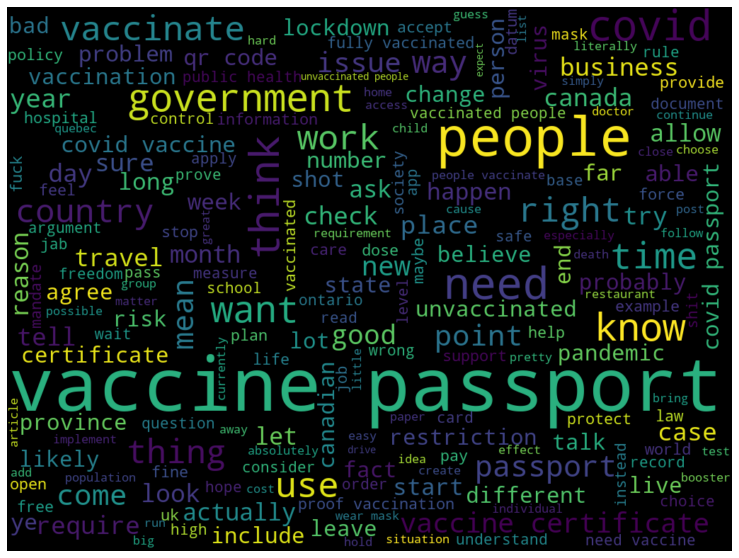

In [21]:
all_comments = ' '.join ( [comments for comments in df['body']])
word_cloud = WordCloud(width=1024, height=768, random_state=21, max_font_size = 120).generate(all_comments)

plt.figure( figsize=(20,10) )
plt.imshow(word_cloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

### 1.8. TextBlob: Subjectivity and Polarity

In [22]:
# create the method to get subjectivity
# subjectivity tells us how subjective or opinionated the text is.
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# create the method to get the polarity
# polarity tells how positive or negative the text is.
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

# Create columns subjectivity and polarity.
save_df['subjectivity'] = save_df['body'].apply(get_subjectivity)
save_df['polarity'] = save_df['body'].apply(get_polarity)

### 1.9. TextBlob: Label data based on polarity value

In [23]:
# Method to label neg., neutral and positive comments
def label_data(score):
    if score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'positive'

save_df['label'] = save_df['polarity'].apply(label_data)

### 1.10 Plotting polarity and subjectivity

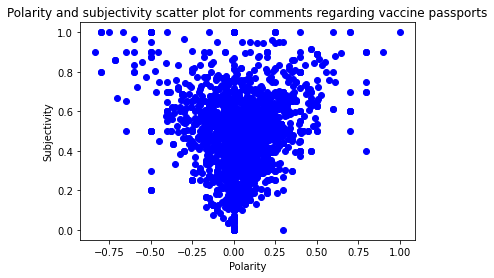

<Figure size 1440x720 with 0 Axes>

In [24]:
# Plot the polarity and subj.
for i in range(0, int((save_df.shape[0])/10)):
    plt.scatter(save_df['polarity'][i], save_df['subjectivity'][i], color='Blue')
    
plt.title('Polarity and subjectivity scatter plot for comments regarding vaccine passports')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.figure( figsize=(20,10) )
plt.show()

### 1.11 An overview of labeled data

In [25]:
positive_comments = save_df[save_df.label == 'positive']
positive_comments = positive_comments['body']

round( (positive_comments.shape[0] / save_df.shape[0]) *100, 1 )

53.4

In [26]:
neg_comments = save_df[save_df.label == 'negative']
neg_comments = neg_comments['body']

round( (neg_comments.shape[0] / save_df.shape[0]) *100, 1 )

29.2

In [27]:
neutral_comments =  save_df[save_df.label == 'neutral']
neutral_comments = neutral_comments['body']

round( (neutral_comments.shape[0] / save_df.shape[0]) *100, 1 )

17.4

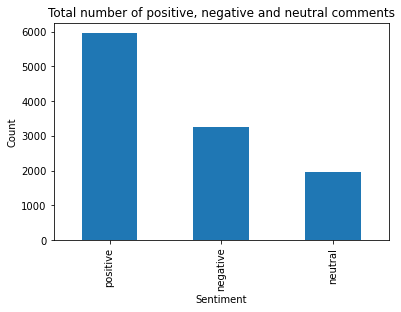

In [28]:
save_df['label'].value_counts()

plt.title('Total number of positive, negative and neutral comments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
save_df['label'].value_counts().plot(kind='bar')
plt.show()

### 1.12 Load and join OWID Dataset for daily COVID-19 cases
>Load and preprocess **Our World In Data (OWID)** Covid dataset.<br>
We will join daily covid cases based on **date** and **new_cases** fields from OWID Dataset.

In [29]:
owid_df = pd.read_csv('../dataset/owid-covid-data.csv')

In [30]:
owid_df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [31]:
# prepare OWID Data for join process
def manipulate_owid_df(text):
    
    text = re.sub(r'((?:United States))', 'CoronavirusUS', text)
    text = re.sub(r'([\s])', '', text) #remove whitespace in country name to match our dataset name
    text = text.lower()
    
    return text

In [32]:
owid_df['location'] = owid_df['location'].apply(manipulate_owid_df)

In [33]:
# drop NaN values for date and new_cases columns.
owid_df.dropna(subset=['date', 'new_cases'], inplace=True)

In [34]:
owid_df['new_cases'].isnull().sum()

0

In [35]:
# will be used for joining
owid_df_join =owid_df[['date', 'location', 'total_cases', 'new_cases']]

### 1.12. Join reddit comments and daily covid cases dataframes
>Apply inner join using intersection of keys from both dataframes.

In [36]:
merged_df = save_df.merge(owid_df_join, how='inner', left_on=['date', 'subreddit'], right_on=['date', 'location'])

### 1.12. Verify whether joining is successful or not

In [37]:
owid_df_join.loc[(owid_df_join.date == '2022-01-23') & (owid_df_join.location == 'australia')]

,date,location,total_cases,new_cases
9417,2022-01-23,australia,2229104.0,32234.0


### 1.13. Save the preprocessed dataset

In [38]:
merged_df.head()

,created_utc,date,body,subreddit,income_group,permalink,subjectivity,polarity,label,location,total_cases,new_cases
0,1.643123e+09,2022-01-25,fair I think home citizenship relevant visa tr...,australia,upper,/r/australia/comments/sccs51/visitor_informati...,0.480000,0.360000,positive,australia,2340046.0,52920.0
1,1.642923e+09,2022-01-23,I shave business day agree pick directly passp...,australia,upper,/r/australia/comments/sao21y/how_long_does_it_...,0.575000,0.200000,positive,australia,2229104.0,32234.0
2,1.642822e+09,2022-01-22,usual mask covid passport event size limit bun...,australia,upper,/r/australia/comments/s9n0mw/who_wants_to_get_...,0.250000,-0.250000,negative,australia,2196870.0,67182.0
3,1.642143e+09,2022-01-14,nz citizen live aus fly plenty fly nz passport...,australia,upper,/r/australia/comments/s3h17y/travelling_to_aus...,0.797222,0.559091,positive,australia,1613249.0,86288.0
4,1.642146e+09,2022-01-14,need person consent record blur face man trave...,australia,upper,/r/australia/comments/s3lz4w/djokovic_visa_can...,0.000000,0.000000,neutral,australia,1613249.0,86288.0


In [ ]:
merged_df.drop(['location'], axis=1, inplace=True)

In [47]:
merged_df.loc[merged_df.isnull().any(axis=1)]

,created_utc,date,body,subreddit,income_group,permalink,subjectivity,polarity,label,total_cases,new_cases


In [48]:
merged_df.dropna(inplace=True)

In [49]:
merged_df.to_csv('preprocessed_all_countries_combined_comments.csv')

In [6]:
df_preprocessed = pd.read_csv('../dataset/preprocessed_all_countries_combined_comments.csv')

In [7]:
print('Number of comments before preprocessing: ', len(df_preprocessed))

Number of comments before preprocessing:  11168
